# Описание модели

В качестве модели для обнаружения аномалий рассмотрим критерий Хотеллинга совместно с Q-статистикой и сравним c результатами применения этой же модели в https://github.com/waico/SKAB

\\( Т^2\\)-критерий фактически является расстоянием Махаланобиса между вектором состояния \\(X_n^{1×D}\\) и вектором средних \\(μ_X^{1×D}\\) трейновой выборки. Для расчета \\( Т^2\\)-критерия на основе метода главных компонент схема расчета следующая: для трейновой выборки (аномалий нет) рассчитываются вектор средних и вектор стандартных отклонений. Далее для центрированных данных применяется преобразование главных компонент (PCA) и находится матрица перевода. После этого данные тестовой выборки нормализуются с использованием векторов средних и стандартных отклонений для трейновой выборки. Далее нормализованная тестовая выборка преобразуется в подпространство главных компонент с параметрами преобразования, определенными по трейновой выборке. Для преобразованных данных рассчитывается \\(Т^2\\) критерий. Формула для расчета \\(Т^2\\)-критерия:
$$T_i^2=t_i∙Σ_T^{-1}∙t_i^T=x_i∙P∙Σ_T^{-1}∙P^T∙x_i^T$$


Где \\(t_i\\) – отображения вектора \\(x_i\\) в пространство главных компонент, \\(P\\) – матрица преобразования в пространство главных компонент, а \\(Σ_T^{-1}\\) – обратная ковариационная матрица.

Значение допустимого предела \\(T_{UCL}^2\\) вычисляется по следующей формуле:
$$T_{UCL}^2  =  \frac{R(N - 1)(N + 1)}{N(N - R)}⋅F_α(R,R-N)$$


где \\(F_α(R, R-N)\\) – \\(F\\)-распределение с \\(R\\) и \\(R - N\\) степенями свободы, соответствующее доверительному интервалу \\(α\\).

\\(Q\\)-критерий позволяет обнаруживать изменения в данных в подпространстве оставшихся компонент (подпространство разностей) после перевода исходных данных в подпространство главных компонент. \\(Q\\)-критерий для \\(i\\)-го измерения определяется по следующей формуле:
$$Q_i = x_i (I - PP^T)x_i^T$$
где \\(P\\) – матрица преобразования в пространство главных компонент.
Допустимое значение для \\(Q\\)-критерия рассчитывается по формуле:
$$Q_{UCL}=[\frac{c_α √(2θ_2 h_0^2 )}{θ_1} +1+\frac{θ_2 h_0 (h_0-1)}{θ_1^2 }] $$
где \\(c_α\\) – значение, соответствующее \\((1-α)\\) верхнему процентилю из нормального распределения. \\(θ_i\\) определяется соотношением:
$$θ_i=∑_{j=k+1}^pλ_j^i, i=1,2,3,  h_0=1-(2θ_1 θ_3)/(3θ_2^2 )$$

# Предобработка

В результате разведочного анализа данных было принято решение провести предобработку данных, состоящую из следующих пунктов:
- приведение данных к равноотстоящему шагу (1 секунда) с линейной интерполяцией пропущенных значений
- удаление выбросов (значений превышающих три стандартных отклонения)
- для показаний акселерометров провести цифровую фильтрацию
- заменить температуру корпуса двигателя, потребляемой мощьностью двигателя
- для оставшихся сигналов удалить шум с помощью усреднения скользящим окном размеров (30 секунд)

# Реализация

In [2]:
import numpy as np
import pandas as pd
import os

from model import AnomalyDetection
# from evaluating import evaluating_change_point

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
all_files = []
for root, dirs, files in os.walk("./SKAB/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(f'{root}/{file}')

In [4]:
# датасет с аномалиями
dfs = [pd.read_csv(file,
                   sep=';',
                   index_col='datetime',
                   parse_dates=True) for file in all_files if 'anomaly-free' not in file]

In [5]:
AD = AnomalyDetection()

In [6]:
df = pd.DataFrame(np.random.randn(100, 4), columns=list('ABCD'))
#     t2 = T2(using_pca=False)
#     t2.fit(df.iloc[:20])
#     t2.predict(df)

In [10]:
df

,A,B,C,D
0,1.187563,-0.745896,-0.131354,-0.181577
1,0.528672,-0.185263,-1.048914,-1.330982
2,0.316225,0.544357,0.175289,-0.014819
3,-0.697851,0.045127,1.346873,1.435725
4,-0.352497,0.031479,0.897250,-1.182588
...,...,...,...,...
95,1.175531,-0.289572,0.275713,1.238858
96,0.008762,0.327410,0.984653,0.497782
97,-1.303042,-0.433316,1.452669,-0.204888
98,-0.381548,-0.778339,0.094853,1.009692


In [9]:
AD.fit_predict(df, fit_interval=20)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
AD.

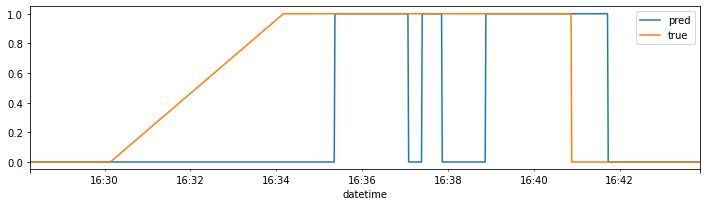

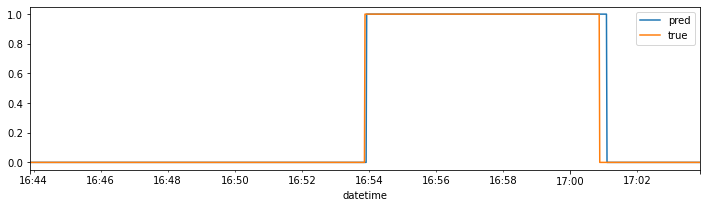

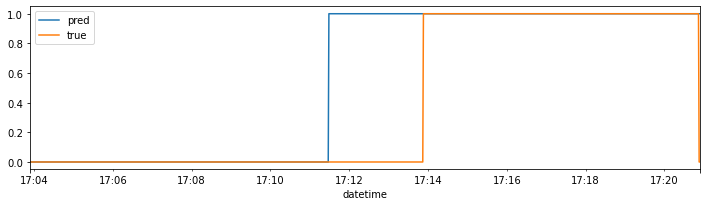

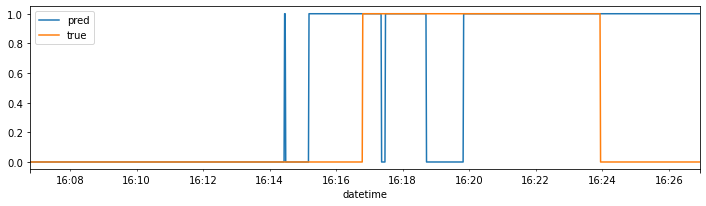

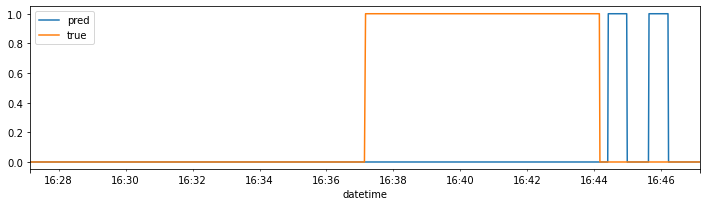

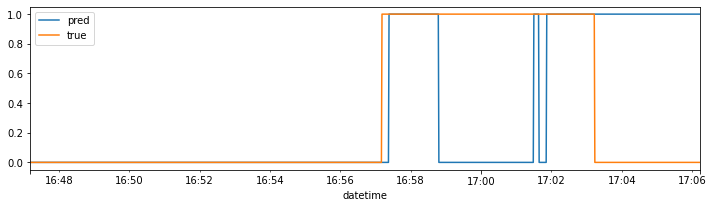

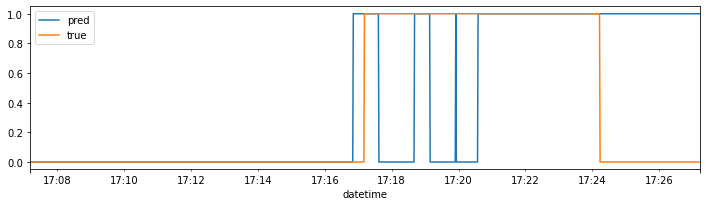

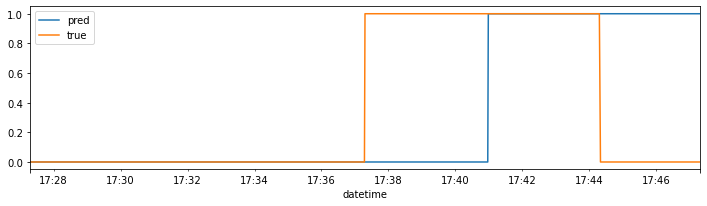

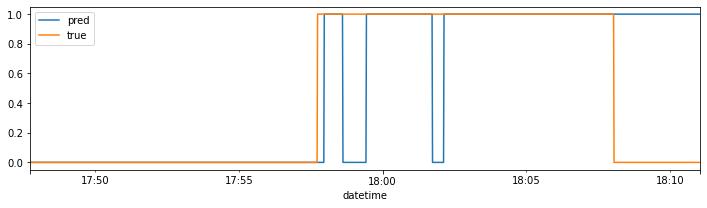

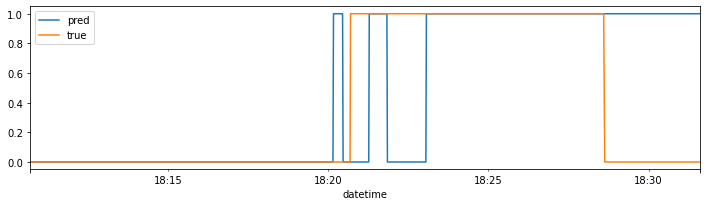

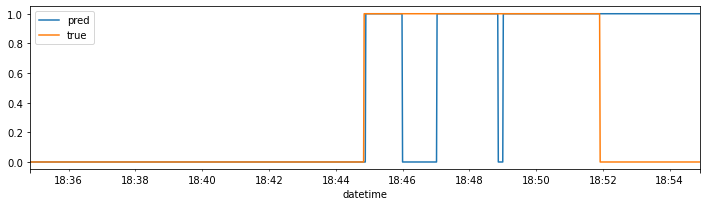

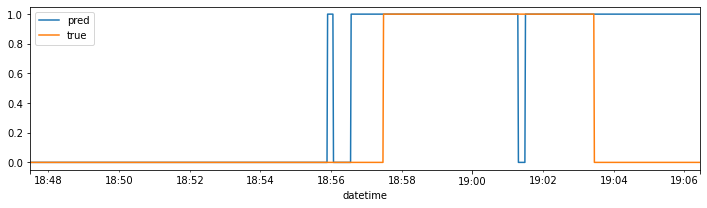

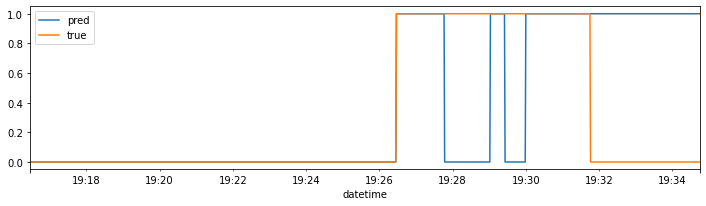

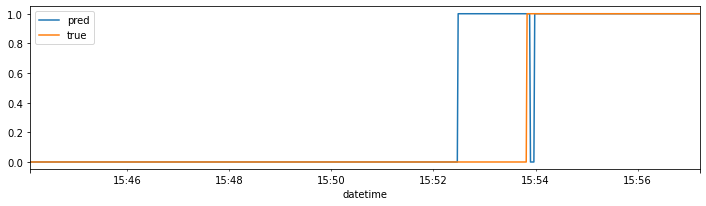

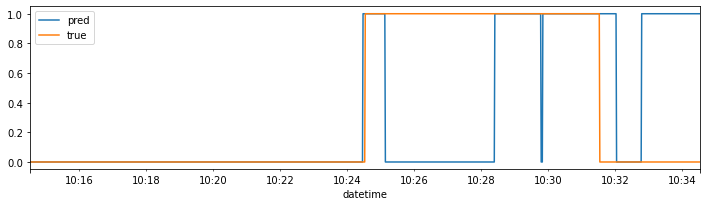

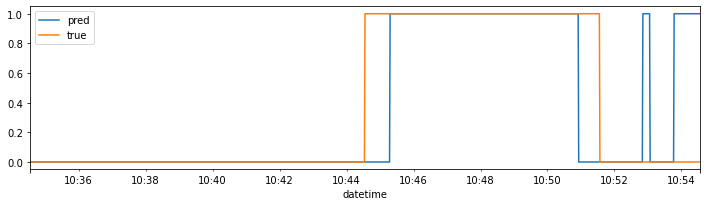

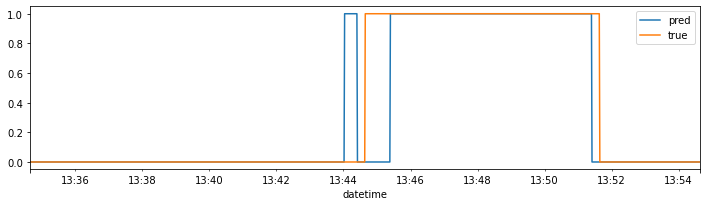

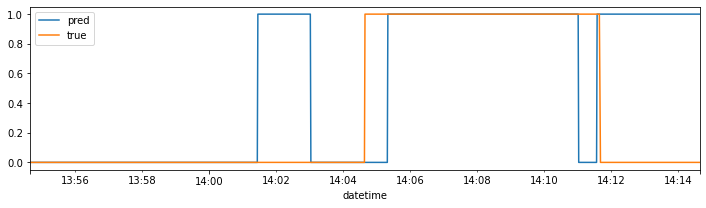

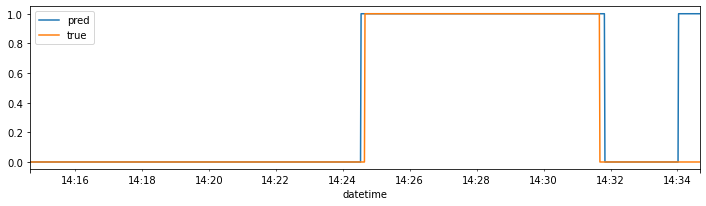

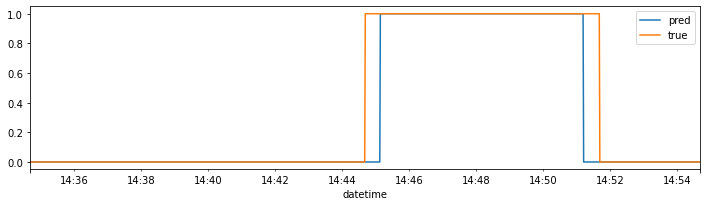

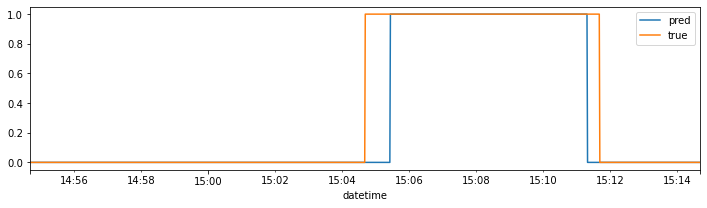

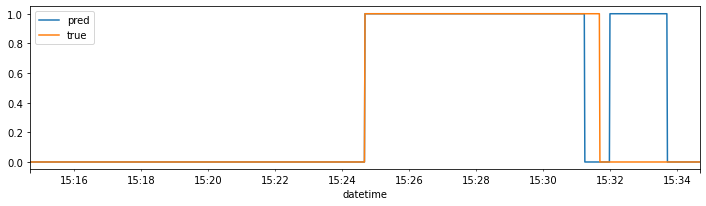

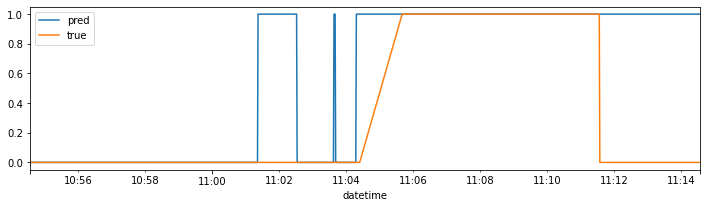

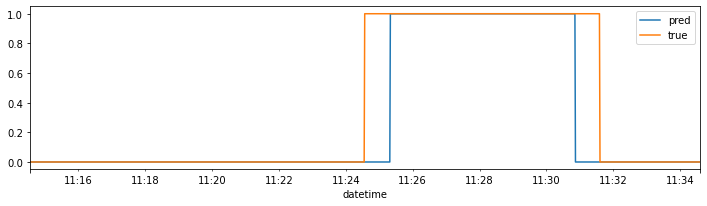

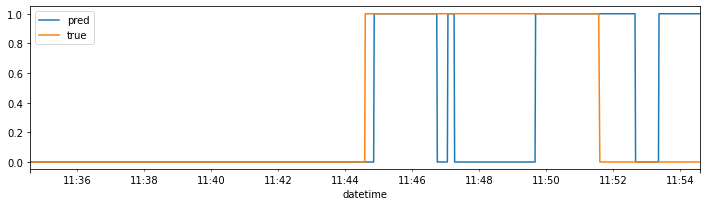

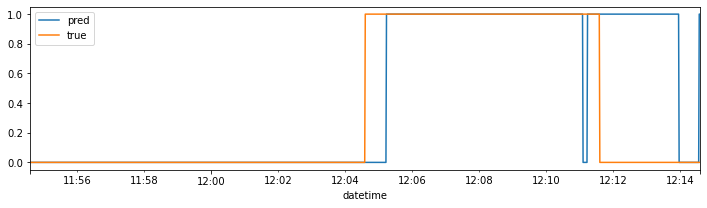

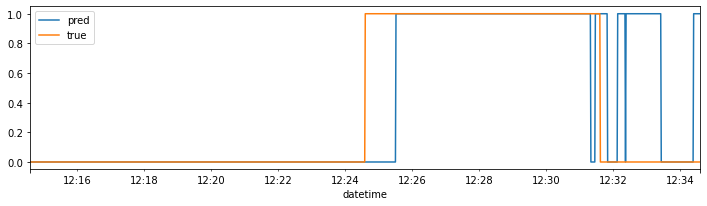

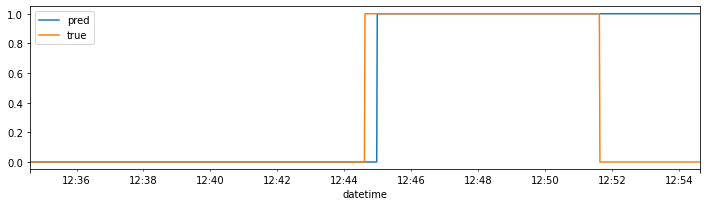

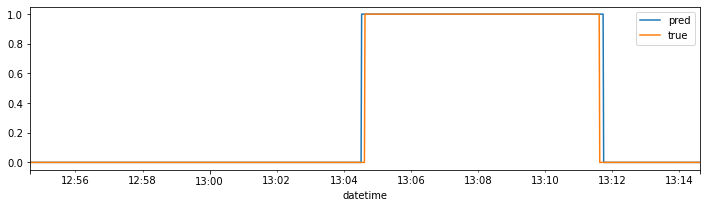

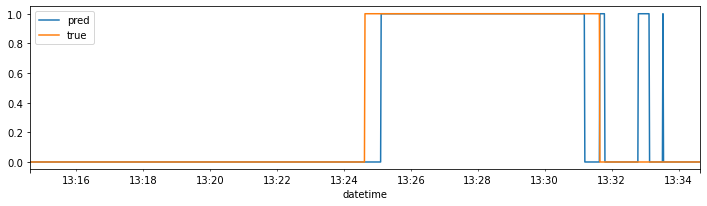

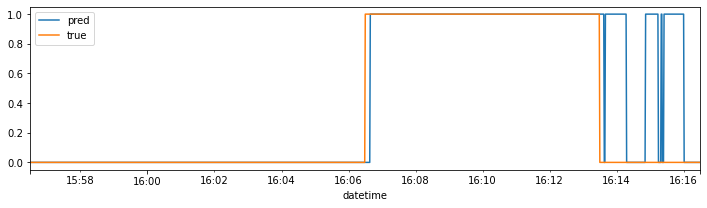

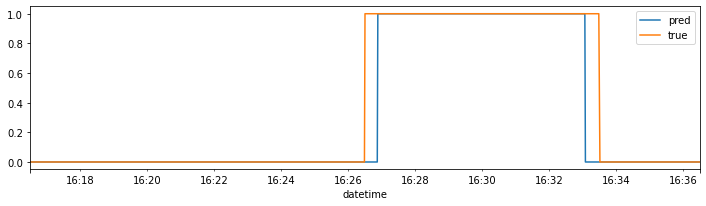

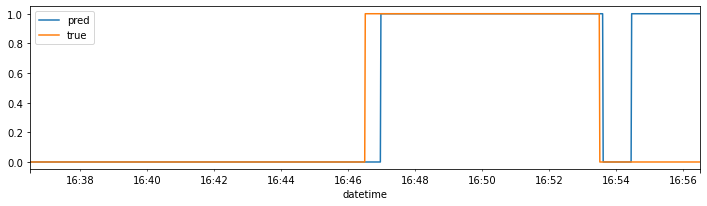

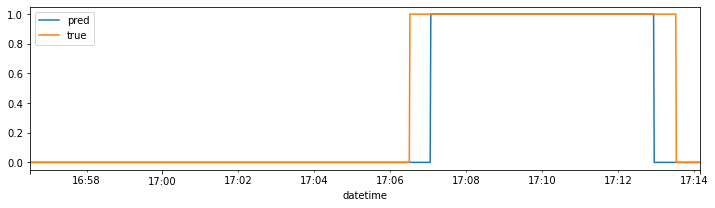

In [5]:
predicted_outlier, predicted_cp = [], []
for df in dfs:
    
    pred = AD.fit_predict(df, fit_interval=400)
    
    predicted_outlier.append(pred)
    
    prediction_cp = abs(pred.diff())
    prediction_cp[0] = pred[0]
    predicted_cp.append(prediction_cp)

    plt.figure(figsize=(12, 3))
    pred.plot(label='pred')
    df.anomaly.plot(label='true')
    plt.legend()

Оценим алгоритм с помощью метрик предложенных в репозитории SKAB

In [6]:
true_cp = [df.changepoint for df in dfs]
# true outlier indices selection
true_outlier = [df.anomaly for df in dfs]

In [7]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 15.25 %
Missing Alarm Rate 19.98 %


In [8]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:16.212121212
A number of missed CPs = 97


In [9]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of the windows of too wide widths for dataset 2
Intersection of the windows of too wide widths for dataset 2
Intersection of the windows of too wide widths for dataset 2
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 6
Intersection of the windows of too wide widths for dataset 9
Intersection of the windows of too wide widths for dataset 9
Intersection of the windows of too wide widths for dataset 9
Intersection of the windows of too wide widths for dataset 10
Intersection of the windows of too wide widths for dataset 10
Intersection of the windows of too wide widths for dataset 10
Intersection of the windows of too wide widths for dataset 12
Intersection of the 

# Вывод

Значения метрик для такой же модели реализованной на https://github.com/waico/SKAB/blob/master/baselines/hotelling_q.ipynb:

![tab1](tab1.PNG)

![tab2](tab2.PNG)

Таким образом, в результате предложенной предобработки данных, для данной модели удалось достичь лучших значений NAB-метрики (больше примено в пять раз). Также стало в два раза меньше пропущенных сигналов тревоги, но увеличелось количество ложных срабатываний.